# Wavelet results confusion matrices

## Occipital classification

### step 1 load data_occipital

In [1]:
%pylab inline
import sklearn
from scipy.io import loadmat
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from scipy.ndimage.interpolation import shift

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load in the final data: all subject,all levels, all orientations;
#data = np.load('data_all_subjects_final_log_BA17.npy')
data = np.load('allsubjs_vstacked_readyfor_classification_occipital.npy')

In [3]:
data.shape 

(512, 5, 28, 8)

512 is all TRs, 5 is 5 levels, 28 orientation, 8 subjects.

In [4]:
#load in all the labels/conditions
subj_lst = ["s1","s2","s3","s5","s6","s7","s8","s10"]
conditions_lst = []

for subject in tqdm(subj_lst):
    
    conditions = loadmat(subject+'/conds_short_tlrc.mat')
    conditions = conditions['conds_short_tlrc']
    conditions_sh2 = shift(conditions,[0,2], cval=0) #shift by 2 TRs
    
    def convert_binary_to_multiclass(binary_conditions):
        """Convert binary representation into multiclass reprentation:
        For example: convert [[1 1 1 1 0 0 0 0]
                              [0 0 0 0 1 1 1 1]]
        to [1 1 1 1 2 2 2 2]"""
        x,y = np.where(binary_conditions)
        conditions=np.zeros(binary_conditions.shape[1])
        conditions[y]=x+1
        return conditions

    conditions_multi = convert_binary_to_multiclass(conditions_sh2)
    
    conditions_lst.append(conditions_multi)


100%|██████████| 8/8 [00:00<00:00, 422.92it/s]


In [5]:
conditions_final = np.vstack (conditions_lst)

In [6]:
#conditions_final.shape

In [7]:
#np.save ("conditions_sh2_final.npy", conditions_final)

In [8]:
# Then I label all the conditions
face = conditions_multi == 1
objects = conditions_multi == 2
place = conditions_multi == 3
fruit = conditions_multi == 4

## Classification analysis


In [9]:
labels = conditions_final.reshape(4096,1)
labels.shape

(4096, 1)

In [10]:
no_res = labels!=0
no_res = no_res.reshape(512*8)# because I will use this as mask, so there is no ',1' in shape

In [11]:
labels_no_res = labels[no_res]
labels_no_res.shape

(1536, 1)

### Classification 06/29/2020

In [12]:
subject = 0 

level = 0

#animals = [1,2,3,4,5,6,7,8,9,10,11,12] # represent all the animals in 3 categories

run = 0


In [13]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

def wavefunc (subject, level, run): 
    """This function calculate each subject, each level,and using leaving one run out cross-validation 
        method for classification. Subjects are from 0-7; levels are from 0-4. For example, wavefunc (0,3,0)"""
    # First I will start with one subject. 

    subj_data = data[:,:,:,subject] # First choose one subject data
    subj_labels = conditions_final[subject,:]

    level_data = subj_data[:,level,:] # Then choose one level data

    #level_data.shape
   # choose the masks corresponding to each category in the pair
    #mask_1 = np.in1d (conditions_multi, animals)# np.in1d you need to make sure what shape you want, the shape you want should be put as the first element.
    #mask_2 = np.in1d (conditions_multi, animals)
    
    # Choose one run data according to the animal pair 
    tr_index = np.arange(512)
    # Each run has 32TRs, to choose the first run, will use the logic below
    #run_mask = np.logical_and(run*128 <= tr_index, tr_index < (run+1)*128) # instead of using leave-one-run-out, so run here is equivalent to folds
    run_mask = np.logical_and(run*32 <= tr_index, tr_index < (run+1)*32) # instead of using leave-one-run-out, so run here is equivalent to folds

    no_res_mask = subj_labels!= 0 
    #print run_mask.shape
    # Select the data by applying the mask
    # category_mask = np.logical_or(mask_1, mask_2)
    # category_mask = category_mask.reshape(1230)

    test_mask = np.logical_and(no_res_mask, run_mask) # choose the category pair and one run data
    train_mask = np.logical_and(no_res_mask,~run_mask) # ~ means invert mask, mean except that mask; choose the animal pairs and other 9 runs data

    #test_data =  level_data[test_mask,:]
    #train_data = level_data[train_mask,:]

    #Next generate the features matrix and label matrix to prep for the classification.
    labels_test = subj_labels[test_mask] # choose the category pair and run masks within all the conditions. test labels
    #labels_test =  (labels_test -1) // 4 # which convert 1-12 to "0,0,0,0, 1,1,1,1,2,2,2,2"
    features_test = level_data [test_mask,:] # test features

    labels_train = subj_labels[train_mask]
    #labels_train =  (labels_train -1) // 4
    features_train = level_data [train_mask,:]

    # Now we can run classification
    #scaler = StandardScaler()

    X_train, X_test = features_train, features_test
    y_train, y_test = labels_train, labels_test
    
    #import pdb ; pdb.set_trace()# stop here to debug
    #X_train_scaler =  scaler.fit_transform (X_train)
    #X_test_scaler=  scaler.transform (X_test)
    
    #Train the model using the training sets
    #model = svm.SVC()
    #model = KNeighborsClassifier(n_neighbors=10) 
    #model = GaussianNB()
    model = XGBClassifier(objective = 'multi:softmax')
    #model = XGBClassifier(silent=False, 
                      #scale_pos_weight=1,
                      #learning_rate=0.01,  
                      #colsample_bytree = 0.4,
                      #subsample = 0.8,
                      #objective='multi:softmax', 
                      #n_estimators=1000, 
                      #reg_alpha = 0.3,
                      #max_depth=4, 
                      #gamma=10)
    model.fit(X_train,y_train)# model fit traning set.

    #Predict Output
    prediction_x_train = model.predict(X_train)
    predicted = model.predict(X_test) # 0:Overcast, 2:Mild
    

    acc = accuracy_score(y_test, predicted)
    
    #return acc
    #return acc,np.array(test_shuffle)
    return acc,y_test,predicted

    #now we have one run data for testing, we need 9 runs data set for training.


In [15]:
wavefunc(3,3,0)

(0.3333333333333333,
 array([1., 1., 1., 4., 4., 4., 2., 2., 2., 3., 3., 3.]),
 array([3., 2., 4., 2., 1., 2., 4., 3., 2., 3., 3., 3.]))

In [14]:
y_test_lst = []
predic_lst = []

for i in tqdm(range (8)):
    for j in range (16):
        acc, y_test, prediction = wavefunc(i,0,j)#change level manually
        y_test_lst.append(y_test)
        predic_lst.append(prediction)

100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


In [16]:
y_test = np.hstack(y_test_lst)
prediction = np.hstack(predic_lst)

In [17]:
import seaborn as sns

(0, 4)

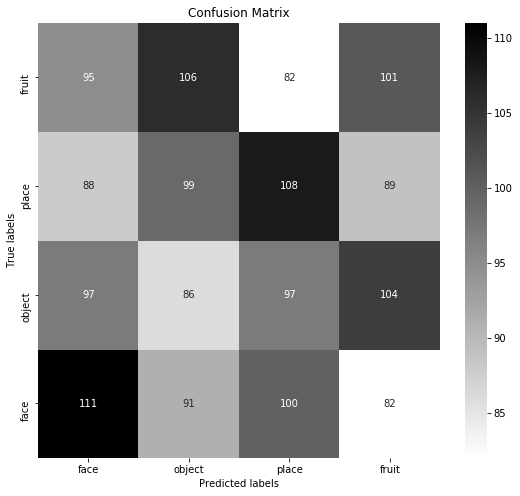

In [30]:
cm = confusion_matrix(y_test, prediction)
fig,ax = plt.subplots(1,1,figsize = (9,8))
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap = 'binary')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['face', 'object','place','fruit']); 
ax.yaxis.set_ticklabels(['face', 'object','place','fruit'])
ax.set_ylim(0,4)
plt.savefig('occi_confusion_L3.png')